<a href="https://colab.research.google.com/github/pushpendra-saini-pks/Aspect-based-sentiment-analysis/blob/main/Aspect_based_sentiment_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nltk gensim numpy pandas matplotlib

In [3]:
from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('SEntFiN-v1.1.csv')
data.head()

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


In [45]:
data['Title'][0]

'spicejet to issue 6 . 4 crore warrants to promoters'

In [6]:
data['Decisions'].value_counts()

,count
Decisions,
"{""Sebi"": ""neutral""}",189
"{""Nifty"": ""neutral""}",146
"{""Nifty"": ""positive""}",59
"{""Sensex"": ""negative""}",52
"{""Gold"": ""negative""}",47
...,...
"{""Greenply"": ""negative""}",1
"{""Glencore"": ""negative"", ""global commodities"": ""negative""}",1
"{""agriculture commodities"": ""negative""}",1


Clean data in the decisions column.

In [7]:
data["Decisions"] = data['Decisions'].apply(lambda x: x.replace('"', '').replace("{", '').replace('}', '').split(": ")[-1])
data.sample(3)

,S No.,Title,Decisions,Words
7301,7302,Monnet Ispat & Energy raises Rs 175 crore,positive,8
10337,10338,Emerging stocks at new 13-month high; politics...,negative,11
9564,9565,Tough for Godrej Properties to cross Rs 680-68...,negative,10


In [8]:
map_decisions = {'neutral': 2, 'positive': 1, "negative": 0} # map data

data["Decisions"] = data["Decisions"].map(map_decisions)

## Tokenization

In [9]:
tokenizator = WordPunctTokenizer() # split data by dividing characters
data["Token_Title"] = [tokenizator.tokenize(sentence.lower()) for sentence in data['Title']]

In [10]:
model = Word2Vec(data["Token_Title"], vector_size=32, min_count=6, window=5).wv # transform words to 32-dim vectors

#### Normalization

In [11]:
data['Title'] = [" ".join(token) for token in data['Token_Title']]

In [12]:
model.most_similar("stock") # find most similar words

[('jsw', 0.9841896891593933),
 ('approve', 0.9812374711036682),
 ('turnaround', 0.9812178611755371),
 ('stk', 0.9809672236442566),
 ('2011', 0.9807689189910889),
 ('launch', 0.980288565158844),
 ('hindalco', 0.9801557660102844),
 ('promoters', 0.9801421165466309),
 ('first', 0.9797992706298828),
 ('holdings', 0.9795008897781372)]

## Visualizing Word Vectors

I'll reduce dimention of vectors by PCA and UMAP. After I visualizing all words-vectors in 2-dim space.

In [13]:
words = sorted(model.key_to_index.keys(),
               key=lambda word: model.get_vecattr(word, "count"),
               reverse=True)[:4000]

words_vectors = np.array([model.get_vector(word) for word in words])

#### PCA

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(2)
scaler = StandardScaler()

scaler_vectors = scaler.fit_transform(words_vectors)
word_vectors_pca = pca.fit_transform(scaler_vectors)

In [15]:
!pip install bokeh

In [16]:
import bokeh.models as bm
import bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()


def draw(x, y, radius=10, alpha=0.25, color='blue', width=600, height=400, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({'x': x, 'y': y, 'color': color, **kwargs})

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, '@' + key) for key in kwargs.keys()]))
    pl.show(fig)
    return fig

In [17]:
draw(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

figure(id='p1004', ...)

In [18]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.5 MB/s eta 0:00:00


In [19]:
import umap

embedding = umap.UMAP(n_neighbors=5).fit_transform(words_vectors)
draw(embedding[:, 0], embedding[:, 1], token=words)

figure(id='p1053', ...)

## Visualizing Phrase Vectors

Compute mean for each phrace by words-vectors.

In [21]:
def get_phrase_embedding(phrase):
    vector = np.zeros([model.vector_size], dtype="float32")
    phrase_tokenized = tokenizator.tokenize(phrase.lower())
    phrase_vector = [model[x] for x in phrase_tokenized if x in model.key_to_index.keys()]

    if len(phrase_vector) != 0:
        vector = np.mean(phrase_vector, axis=0)

    return vector

In [22]:
get_phrase_embedding(str(np.array(data['Title'][0])))

array([-0.02800829, -1.3337648 ,  0.6669761 ,  1.168567  ,  0.6757701 ,
       -0.9268233 ,  0.5785921 ,  0.28081977, -0.34014118,  0.09530216,
       -0.27153003, -0.25554112,  1.114286  , -0.30217546,  0.09557389,
       -0.440422  ,  0.23276952,  0.17991391, -0.06791876,  0.5938996 ,
        0.76156795,  2.0391612 ,  1.4049753 , -0.5025392 , -0.07787807,
       -0.04598007, -0.7201607 , -0.2483837 ,  0.11801609, -0.45816076,
       -0.1834998 ,  0.05208248], dtype=float32)

In [23]:
chosen_phrases = data['Title'][:4000]
phrases_vector = np.asarray([get_phrase_embedding(x) for x in chosen_phrases])

In [24]:
umap_phrases_vector = umap.UMAP(n_neighbors=3).fit_transform(phrases_vector) # reduce dimention by UMAP

In [25]:
draw(umap_phrases_vector[:, 0], umap_phrases_vector[:, 1], radius=20, phrase=[phrase[:50] for phrase in chosen_phrases]) # draw vectors

figure(id='p1102', ...)

## Clusterization

Let's make clusterization for phrase with help KMeans.

In [26]:
from sklearn.cluster import DBSCAN, KMeans

kmeans = KMeans(3)
labels = kmeans.fit_predict(np.asarray(phrases_vector))

colors = ['red', 'green', 'blue']

In [27]:
draw(umap_phrases_vector[:, 0], umap_phrases_vector[:, 1],
     color = [colors[l] for l in labels], phrase=[phrase[:50] for phrase in chosen_phrases],
     radius=20)

figure(id='p1151', ...)

## Classification with standart ML algorithms

Let's make a prediction of the label by the phrase vector. For this task I'll apply some machine learning algorithms. And finaly I stack all algorihms.

In [28]:
from sklearn.preprocessing import StandardScaler

full_phrases_vectors = np.asarray([get_phrase_embedding(x) for x in data['Title']])
scaler_vectors = StandardScaler().fit_transform(full_phrases_vectors)

**Decision Tree**

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaler_vectors, data["Decisions"], test_size=0.3)

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay # Import ConfusionMatrixDisplay instead

tree = DecisionTreeClassifier(max_depth=8, max_leaf_nodes=12)
tree.fit(X_train, y_train)

print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))



0.5548027102431248
0.5120892746435214


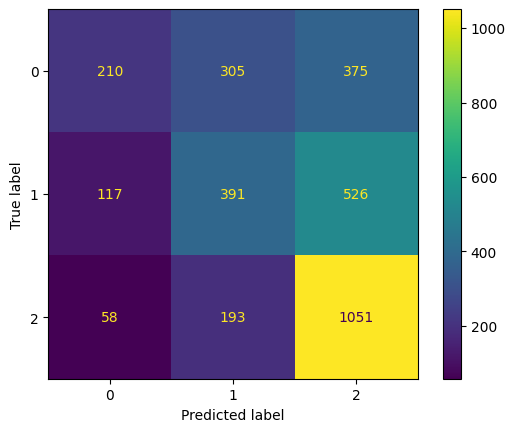

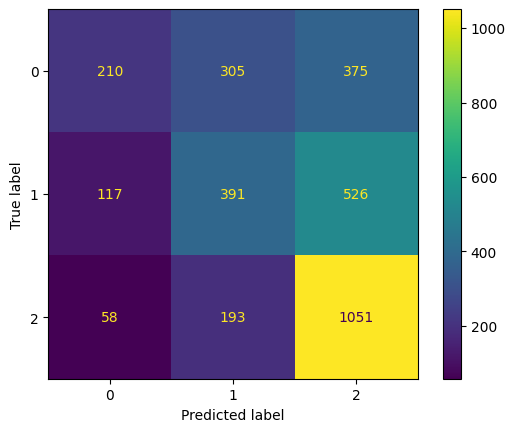

In [34]:
# Use ConfusionMatrixDisplay to create the plot
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test).plot()
plt.show()

**Logistic regression**

In [35]:
log_reg = LogisticRegression(C=0.02)
log_reg.fit(X_train, y_train)

print(log_reg.score(X_train, y_train), log_reg.score(X_test, y_test))

0.5437757406669324 0.5247985120892746


In [36]:
print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.52      0.27      0.35       890
           1       0.52      0.35      0.42      1034
           2       0.52      0.84      0.65      1302

    accuracy                           0.52      3226
   macro avg       0.52      0.49      0.47      3226
weighted avg       0.52      0.52      0.49      3226



**Random Forest**

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=50, max_depth=13)
forest.fit(X_train, y_train)

print(forest.score(X_train, y_train), forest.score(X_test, y_test))

0.8788361897170187 0.5619962802231866


In [38]:
print(classification_report(y_train, forest.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1966
           1       0.98      0.79      0.88      2330
           2       0.79      0.99      0.88      3231

    accuracy                           0.88      7527
   macro avg       0.92      0.86      0.88      7527
weighted avg       0.90      0.88      0.88      7527



**Gradient Boosting**

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

boost = GradientBoostingClassifier()
boost.fit(X_train, y_train)

print(boost.score(X_train, y_train), boost.score(X_test, y_test))

0.6428856117975289 0.5592064476131432


In [57]:
print(classification_report(y_train,boost.predict(X_train)))

              precision    recall  f1-score   support

           0       0.68      0.45      0.54      1966
           1       0.66      0.48      0.56      2330
           2       0.63      0.87      0.73      3231

    accuracy                           0.64      7527
   macro avg       0.65      0.60      0.61      7527
weighted avg       0.65      0.64      0.63      7527



**Stacking**

In [40]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lr', LogisticRegression(C=0.01)),
    ('boost', GradientBoostingClassifier()),
    ('rf', RandomForestClassifier(n_estimators=150))
]

stackingClf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stackingClf.fit(X_train, y_train)

StackingClassifier(estimators=[('lr', LogisticRegression(C=0.01)),
                               ('boost', GradientBoostingClassifier()),
                               ('rf',
                                RandomForestClassifier(n_estimators=150))],
                   final_estimator=LogisticRegression())

In [50]:
X_train

array([[-0.03858328,  0.3737154 , -1.7133486 , ..., -2.2809334 ,
         1.2347862 , -1.1142949 ],
       [-1.2742879 ,  0.13200626,  0.32021186, ...,  0.6554206 ,
         0.6403961 , -0.14554708],
       [-0.47392204,  0.7447564 , -0.70430344, ...,  0.08012189,
         0.83229095,  0.62346715],
       ...,
       [ 0.04633019, -0.07524525,  0.33896846, ...,  0.31282696,
        -0.23058224, -0.26024806],
       [-0.2904955 ,  0.46844304, -0.811593  , ..., -0.09983075,
         0.78559124,  0.40654722],
       [ 2.70199   , -3.1092722 ,  2.5476458 , ...,  1.0876448 ,
        -2.5230262 , -2.5323174 ]], dtype=float32)

In [41]:
stackingClf.score(X_train, y_train)

0.9922944068021788

In [42]:
stackingClf.score(X_test, y_test)

0.5734655920644761

In [52]:
first_sen = get_phrase_embedding(str(np.array(data['Title'][0])))

In [55]:
stackingClf.predict(first_sen.reshape(1, -1))

array([2])

In [59]:
print(classification_report(y_train, stackingClf.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1966
           1       1.00      0.99      1.00      2330
           2       0.99      1.00      0.99      3231

    accuracy                           0.99      7527
   macro avg       0.99      0.99      0.99      7527
weighted avg       0.99      0.99      0.99      7527

